In [1]:
from factor_transducer import *
import sentencepiece as spm
import k2
from tokenizer import *

## Previous

In [2]:
sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
sp = spm.SentencePieceProcessor(model_file=str(sp_model_path))

token2id = {sp.id_to_piece(i): i for i in range(sp.vocab_size())}
id2token = {v: k for k, v in token2id.items()}

del token2id[id2token[0]]
token2id["<eps>"] = 0
id2token[0] = "<eps>"

word_start_symbols = [i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]

In [3]:
text = "pen apple aaaz"
text_encoded = sp.encode(text, out_type=int)

# text_encoded = [24, 102, 70]
# text_encoded = [49, 11, 7, 161, 24]
# text_encoded = [49, 11, 7, 49, 49, 161, 24]

print(text_encoded)
print([sp.id_to_piece(p) for p in text_encoded])

[340, 15, 7, 208, 44, 7, 38, 38, 186]
['▁pe', 'n', '▁a', 'pp', 'le', '▁a', 'a', 'a', 'z']


In [9]:
# fst = make_factor_transducer1(text_encoded, return_str=False, blank_penalty=0)
fst = make_factor_transducer2(text_encoded, return_str=False, blank_penalty=-22)
# fst = make_factor_transducer3(text_encoded, word_start_symbols, return_str=False, blank_penalty=0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in token2id.items()]))
fst.aux_labels_sym = fst.labels_sym

In [12]:
# fst = make_factor_transducer4(text_encoded, word_start_symbols, return_str=False, blank_penalty=0)
fst = make_factor_transducer4_skip(text_encoded, word_start_symbols, return_str=False, blank_penalty=-22.0, skip_penalty=-0.1, return_penalty=-10.0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in token2id.items()]))
fst.aux_labels_sym = k2.SymbolTable.from_str("\n".join([f"{v} {k+1}" for k, v in enumerate(text.split() + [None])]))

Num nodes: 21
Num arcs:  63


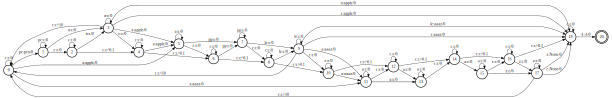

In [13]:
print(f"Num nodes: {fst.shape[0]}")
print(f"Num arcs:  {fst.num_arcs}")
k2.to_dot(fst)

[340, 15, 7, 208, 44, 7, 38, 38, 186]
Num nodes: 20
Num arcs:  46


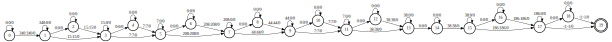

In [10]:
fst_graph = k2.ctc_graph([flatten_list(text_encoded)], modified=False, device='cpu')[0]
print(flatten_list(text_encoded))
print(f"Num nodes: {fst_graph.shape[0]}")
print(f"Num arcs:  {fst_graph.num_arcs}")
k2.to_dot(fst_graph)

In [9]:
print(k2.to_str_simple(fst_graph))

0 0 0 0 0
0 1 340 340 0
1 2 0 0 0
1 1 340 0 0
1 3 15 15 0
2 2 0 0 0
2 3 15 15 0
3 4 0 0 0
3 3 15 0 0
3 5 7 7 0
4 4 0 0 0
4 5 7 7 0
5 6 0 0 0
5 5 7 0 0
5 7 208 208 0
6 6 0 0 0
6 7 208 208 0
7 8 0 0 0
7 7 208 0 0
7 9 44 44 0
8 8 0 0 0
8 9 44 44 0
9 10 0 0 0
9 9 44 0 0
9 11 7 7 0
10 10 0 0 0
10 11 7 7 0
11 12 0 0 0
11 11 7 0 0
11 13 38 38 0
12 12 0 0 0
12 13 38 38 0
13 14 0 0 0
13 13 38 0 0
14 14 0 0 0
14 15 38 38 0
15 16 0 0 0
15 15 38 0 0
15 17 186 186 0
16 16 0 0 0
16 17 186 186 0
17 18 0 0 0
17 17 186 0 0
17 19 -1 -1 0
18 18 0 0 0
18 19 -1 -1 0
19



## Now

In [2]:
text = "pen apple"
text = "pen apple aaaz"

tokenizer = EnglishPhonemeTokenizer()
text_encoded = tokenizer.encode(text, out_type=int)

# labels = ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
# tokenizer = EnglishCharTokenizer(
#     token2id={c: i for i, c in enumerate(labels)},
#     blk_token="-",
#     unk_token="|",
# )
# text_encoded = tokenizer.encode(text.upper().replace(" ", " | ").strip(), out_type=int)

# labels = ('-', 'a', 'i', 'e', 'n', 'o', 'u', 't', 's', 'r', 'm', 'k', 'l', 'd', 'g', 'h', 'y', 'b', 'p', 'w', 'c', 'v', 'j', 'z', 'f', "'", 'q', 'x')
# tokenizer = EnglishCharTokenizer(
#     token2id={c: i for i, c in enumerate(labels)},
#     blk_token="-",
#     unk_token="-",
# )
# text_encoded = tokenizer.encode(text, out_type=int)

# sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
# sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
# tokenizer = EnglishBPETokenizer(
#     sp_model=sp_model,
#     blk_token="<s>",  # You have to make sure these tokens are in the sp model 
#     unk_token="<unk>",
# )
# text_encoded = tokenizer.encode(text, out_type=int)

print(text_encoded)
print(tokenizer.decode(text_encoded))

[[[27, 11, 23]], [[2, 27, 3, 21]], [[1, 38]]]
[[['P', 'EH', 'N']], [['AE', 'P', 'AH', 'L']], [['AA', 'Z']]]


In [3]:
# fst = make_ctc_graph(text_encoded)
# fst = make_factor_transducer_basic(text_encoded, blank_penalty=-22.0)
# fst = make_factor_transducer_word_level(text_encoded, blank_penalty=-22.0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in tokenizer.token2id.items()]))
fst.aux_labels_sym = fst.labels_sym

NameError: name 'fst' is not defined

In [4]:
# fst, word_index_sym_tab, token_sym_tab = make_factor_transducer_word_level_index(text_encoded, blank_penalty=-22.0)
fst, word_index_sym_tab, token_sym_tab = make_factor_transducer_word_level_index_with_skip(text_encoded, blank_penalty=0, skip_penalty=-0.5, return_penalty=-18.0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in tokenizer.token2id.items()]))
text_splitted = text.split() + [None]
fst.aux_labels_sym = k2.SymbolTable.from_str("\n".join(set([f"{text_splitted[word_index_sym_tab[k]]}-{k} {k}" if k > 0 and k in word_index_sym_tab else f"{k} {k}" if k >=0 else "" for k in fst.aux_labels.tolist()])))

In [5]:
print(fst.aux_labels_sym.to_str())

0 0
pen-1 1
2 2
3 3
apple-4 4
5 5
6 6
7 7
aaaz-8 8
9 9
None-10 10
19 19
20 20



In [5]:
print(fst.to_str())

k2.Fsa: 0 0 0 0 0
0 15 1 8 0
0 7 2 4 0
0 1 27 1 0
1 2 0 0 0
1 3 11 2 0
1 1 27 0 0
2 2 0 0 0
2 4 0 10000000 -0.5
2 3 11 2 0
3 4 0 0 0
3 3 11 0 0
3 5 23 3 0
4 4 0 0 0
4 6 0 10000000 -0.5
4 5 23 3 0
5 0 0 10000001 -18
5 6 0 0 0
5 19 0 4 0
5 7 2 4 0
5 5 23 0 0
5 19 23 4 0
6 6 0 0 0
6 7 2 4 0
7 8 0 0 0
7 7 2 0 0
7 9 27 5 0
8 8 0 0 0
8 10 0 10000000 -0.5
8 9 27 5 0
9 10 0 0 0
9 11 3 6 0
9 9 27 0 0
10 10 0 0 0
10 12 0 10000000 -0.5
10 11 3 6 0
11 12 0 0 0
11 11 3 0 0
11 13 21 7 0
12 12 0 0 0
12 14 0 10000000 -0.5
12 13 21 7 0
13 0 0 10000001 -18
13 14 0 0 0
13 19 0 8 0
13 15 1 8 0
13 13 21 0 0
13 19 21 8 0
14 14 0 0 0
14 15 1 8 0
15 16 0 0 0
15 15 1 0 0
15 17 38 9 0
16 16 0 0 0
16 17 38 9 0
17 0 0 10000001 -18
17 18 0 0 0
17 19 0 10 0
17 17 38 0 0
17 19 38 10 0
18 18 0 0 0
18 19 0 10 0
19 19 0 0 0
19 20 -1 -1 0
20
properties_str = "Valid|Nonempty|ArcSorted|MaybeAccessible|MaybeCoaccessible".
aux_labels: tensor([       0,        8,        4,        1,        0,        2,        0,
            

Num nodes: 21
Num arcs:  64


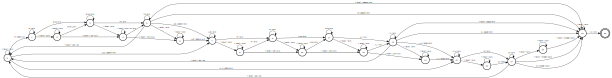

In [6]:
print(f"Num nodes: {fst.shape[0]}")
print(f"Num arcs:  {fst.num_arcs}")
k2.to_dot(fst)

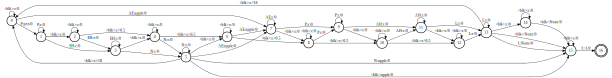

In [6]:
fst.draw("/exp/rhuang/meta/audio_latest/examples/asr/librispeech_alignment/alignment/output.svg")

In [6]:
def test_make_ctc_graph(text="pen apple aaaz"):
    sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
    sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
    
    tokenizer = EnglishBPETokenizer(
        sp_model=sp_model,
        blk_token="<s>",  # You have to make sure these tokens are in the sp model 
        unk_token="<unk>",
    )
    text_encoded1 = tokenizer.encode(text, out_type=int)
    # text_encoded1_check = tokenizer.decode(text_encoded)
    
    text_encoded2 = sp_model.encode(text, out_type=int)
    # text_encoded2_check = [sp.id_to_piece(p) for p in text_encoded2]

    fst_graph1 = make_ctc_graph(text_encoded1)
    # print(f"Num nodes 1: {fst_graph1.shape[0]}")
    # print(f"Num arcs 1:  {fst_graph1.num_arcs}")
    # k2.to_dot(fst_graph1)

    fst_graph2 = k2.ctc_graph([text_encoded2], modified=False, device='cpu')[0]
    # print(f"Num nodes 2: {fst_graph2.shape[0]}")
    # print(f"Num arcs 2:  {fst_graph2.num_arcs}")
    # k2.to_dot(fst_graph2)

    s1 = k2.to_str_simple(k2.arc_sort(fst_graph1))
    s2 = k2.to_str_simple(k2.arc_sort(fst_graph2))

    assert s1 == s2
    print("Sucessful!")
    return s1, s2

s1, s2 = test_make_ctc_graph()

Sucessful!


In [8]:
def test_make_factor_transducer1(text="pen apple aaaz"):
    sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
    sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
    
    tokenizer = EnglishBPETokenizer(
        sp_model=sp_model,
        blk_token="<s>",  # You have to make sure these tokens are in the sp model 
        unk_token="<unk>",
    )
    text_encoded1 = tokenizer.encode(text, out_type=int)
    # text_encoded1_check = tokenizer.decode(text_encoded)
    
    text_encoded2 = sp_model.encode(text, out_type=int)
    # text_encoded2_check = [sp.id_to_piece(p) for p in text_encoded2]

    fst_graph1 = make_factor_transducer_basic(text_encoded1, return_str=False, blank_penalty=0)
    # print(f"Num nodes 1: {fst_graph1.shape[0]}")
    # print(f"Num arcs 1:  {fst_graph1.num_arcs}")
    # k2.to_dot(fst_graph1)

    fst_graph2 = make_factor_transducer1(text_encoded2, return_str=False, blank_penalty=0)
    # print(f"Num nodes 2: {fst_graph2.shape[0]}")
    # print(f"Num arcs 2:  {fst_graph2.num_arcs}")
    # k2.to_dot(fst_graph2)

    s1 = k2.to_str_simple(k2.arc_sort(fst_graph1))
    s2 = k2.to_str_simple(k2.arc_sort(fst_graph2))

    assert s1 == s2
    print("Sucessful!")
    return s1, s2

s1, s2 = test_make_factor_transducer1()

Sucessful!


In [6]:
fst.skip_id, fst.return_id

(1000000.0, 1000001.0)

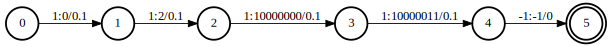

In [31]:
fst_str = '''
0 1 1 0 0.1
1 2 1 2 0.1
2 3 1 10000000 0.1
3 4 1 10000011 0.1
4 5 -1 -1 0
5
'''
k2.to_dot(k2.Fsa.from_str(fst_str, acceptor=False))